In [516]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import datetime
import time

import warnings
warnings.filterwarnings('ignore')
import pickle

seed = 32


ANOMALY = True # False means that we will not do the anomalies detection
LOAD_ORIGINAL_DATA = False # False means that we will use noised data
USE_DAILY_DATA= True # False means tha we will usoe monthly data
data_file = 'hma_full_data.csv'

# Read and concatenate original data

In [517]:
def read_and_reformate_data(path):
    original_data = pd.read_csv(path)
     ### derive PLV_Totale and drop PLV of all stations
    original_data['PLV'] = original_data.iloc[:,4:24].sum(axis=1)    
    original_data.drop(original_data.iloc[:,4:23], axis=1, inplace=True)
    original_data.to_csv('hma_full_data.csv',index=False, sep=',')
    return original_data

In [518]:
data = read_and_reformate_data('full_dataset.csv')

# Anomalies injection

In [519]:
# Read adn preprocess original data
def read_and_preprocess_data(path):
    data = pd.read_csv(path)
    inter = data[['Temp_min']]
    data['Temp_min']  = data[['Temp_max']]
    data['Temp_max'] = inter
    data = data.set_index(data['DATE'])
    data = data.drop(['DATE'],axis=1)
    data.drop_duplicates(keep='first', inplace=True)
    data.interpolate(inplace=True)
    data = data.fillna(method='ffill')
    data.dropna(axis=0, inplace=True)
    return data.drop(['APP'],axis=1), data[['APP']]

In [520]:
data, water_infow = read_and_preprocess_data(data_file)

In [521]:
import sys
sys.path.append('./agots-master')
from agots.multivariate_generators.multivariate_data_generator import MultivariateDataGenerator
df = data.copy()
dg = MultivariateDataGenerator(df)

In [522]:
def grouped(iterable, n):
    return zip(*[iter(iterable)]*n)

In [523]:
## Create ramdom extreme noise
## This method return indexs in which we will inject extreme noise in the data
import random
def random_extreme_noise(df, percent=10):
    x = list(range(0, len(df)))
    #3% of the data will be anomalies
    index_of_anomalies = random.sample(x,  (int((len(df)*percent)/100)))
    index_of_anomalies.sort()
    result = []
    for ano in index_of_anomalies:
        result.append((df.index[ano],))
    return result

In [524]:
## Create ramdom varience or shift noise
## This method return indexs in which we will inject extreme noise in the data
def random_variance_or_shift_noise(df, percent=3):
    x = list(range(0, len(df)))
    #3% of the data will be anomalies
    index_of_anomalies = random.sample(x,  (int((len(df)*percent)/100)))
    index_of_anomalies.sort()
    result = []
    for x, y in grouped(index_of_anomalies, 2):
        result.append((df.index[x],df.index[y]))
    return result

In [525]:
## Create ramdom trend noise
## This method return indexs in which we will inject extreme noise in the data
def random_trend_noise(df, percent=0.08):
    x = list(range(0, len(df)))
    #0.1% of the data will be anomalies
    index_of_anomalies = random.sample(x,  (int((len(df)*percent)/100)))
    index_of_anomalies.sort()
    result = []
    for x, y in grouped(index_of_anomalies, 2):
        result.append((df.index[x],df.index[y]))
    return result

In [526]:
## This method is used to add different types of noise to the Data
def add_noise_to_df(df, display_charts):
    all_noise_indexs_for_all_cols = []
    
    for col in df.columns:
        noise_indexs_for_curr_col = []
        extreme_noise=random_extreme_noise(df)
        variance_or_shift_noise = random_variance_or_shift_noise(df, percent=15)
        trend_noise = random_trend_noise(df)
        noise_indexs_for_curr_col.append(extreme_noise)
        
        noise_indexs_for_curr_col.append(variance_or_shift_noise)
        ##noise_indexs_for_curr_col.append(trend_noise)
        noise_indexs_for_curr_col.append(variance_or_shift_noise)
      
    
        dd = dg.add_outliers({'extreme': [{'n': df.columns.get_loc(col), 'timestamps': extreme_noise,
                                   'value': 0.5
                                  }],#'trend':   [{'n': df.columns.get_loc(col), 'timestamps': trend_noise, 'value': 0.10}]
                      'shift':   [{'n': df.columns.get_loc(col), 'timestamps': variance_or_shift_noise,
                                   'value': -0.4  # or 'value' (for a plain addition)
                                  }],
                      'variance':[{'n': df.columns.get_loc(col), 'timestamps': variance_or_shift_noise,
                                   'value': 0.2
                                  }]
                     })
        
        if display_charts == True:
            fig = plt.figure(figsize=(20,10))
            plt.title(col,fontsize=26, fontweight='bold')
            box = dict(facecolor='yellow', pad=5, alpha=0.2)  

            ax = fig.add_subplot(1, 2, 1)
            ax.plot(data.index, data[col], color='blue', label='Origonal data')
            plt.xlabel('Time')
            plt.ylabel(col, bbox=box)
            plt.legend() 

            ax = fig.add_subplot(1, 2, 2)
            ax.plot(dd.index,dd[col], color='red', label='Noised data')
            plt.xlabel('Time')
            plt.ylabel(col, bbox=box)
            plt.legend() 
            plt.show()
        
        all_noise_indexs_for_all_cols.append(noise_indexs_for_curr_col)
    return dd, all_noise_indexs_for_all_cols

In [527]:
display_charts = False
noised_df, noise_indexs = add_noise_to_df(df, display_charts)
noised_df['APP'] = water_infow

In [528]:
pickle.dump(noised_df, open('noised_df.pkl', 'wb'))
pickle.dump(noise_indexs, open('noise_indexs.pkl', 'wb'))

# Load Data

In [529]:
# Here we can load two types of Data, the original data of the noised data
def read_original_data(data_file, LOAD_ORIGINAL_DATA):
    ## hre we load the original data that does not contain injected anomalies
    if LOAD_ORIGINAL_DATA== True:
        data = pd.read_csv(data_file)
        inter = data[['Temp_min']]
        data['Temp_min']  = data[['Temp_max']]
        data['Temp_max'] = inter
        data = data.set_index(data['DATE'])
        climatic_data = data.drop(['DATE','APP'],axis=1)
        inflow = data[['APP']]
        return climatic_data, inflow
    ## here we load data in which we have injeced anomalies
    else:
        climatic_data = pickle.load(open('noised_df.pkl', 'rb'))
        inflow = climatic_data[['APP']]
        climatic_data  = climatic_data.drop(['APP'],axis=1)
        noise_indexs = pickle.load(open('noise_indexs.pkl', 'rb'))
        return climatic_data, inflow, noise_indexs

In [530]:
if LOAD_ORIGINAL_DATA == True:
    climatic_data, inflow = read_original_data(data_file, LOAD_ORIGINAL_DATA)
else:
    climatic_data, inflow, noise_indexs = read_original_data(data_file, LOAD_ORIGINAL_DATA)

# Visualize Time Series

In [531]:
def plot_ts(df, x, y, title="", xlabel='Date', ylabel="", dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
# Inflow
#plot_ts(inflow, x=inflow.index, y=inflow.APP, ylabel='APP', title='Apport en eau monsuel de Aôut 1986 à Décembre 2009.') 
# Temp_min
#plot_ts(climatic_data, x=climatic_data.index, y=climatic_data.Temp_min, ylabel='Temp_min', title='Température minimale journalière de 1968-01-01 à 2009-12-01.') 
# Temp_max
#plot_ts(climatic_data, x=climatic_data.index, y=climatic_data.Temp_max, ylabel='Temp_max', title='Température maximale journalière de 1968-01-01 à 2009-12-01.') 
# EVA
#plot_ts(climatic_data, x=climatic_data.index, y=climatic_data.EVA, ylabel='EVA', title='Evaporation journalière de 1968-01-01 à 2009-12-01.') 
# PLV
#plot_ts(climatic_data, x=climatic_data.index, y=climatic_data.PLV, ylabel='PLV', title='Précipitation journalière de 1968-01-01 à 2009-12-01.') 

# Data Preprocessing

In [532]:
def preprocessing(original_data):
    clean_data = original_data.copy()
    clean_data.drop_duplicates(keep='first', inplace=True)
    ### fill missing data 
    clean_data.interpolate(inplace=True)
    clean_data.fillna(method='bfill',inplace=True)    
    print('missing values:',clean_data.isna().sum().sum())
    return clean_data

climatic_data_cleaned = preprocessing(climatic_data)
climatic_data_cleaned.describe()

missing values: 0


,Temp_max,Temp_min,Vent,PLV,EVA
count,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000
mean,25.019198,15.024590,26.216288,23.228429,3.954186
std,7.232611,5.923140,7.937219,71.480788,2.934383
min,5.607460,-6.400872,5.000000,-201.420027,-2.193130
25%,19.000000,10.197335,21.000000,0.000000,1.643545
50%,24.647081,15.000000,26.000000,1.861222,3.060000
75%,31.000000,20.000000,30.978368,22.369229,6.030794
max,47.000000,28.916192,67.664463,1442.431692,13.278798


# Split Into 4 Seasonal Datasets

In [533]:
saisons = ['Automne', 'Hiver', 'Printemps', 'Eté']

def create_seasonal_data(full_data):
    data = [pd.DataFrame() for i in range(4)]     
    month = pd.DatetimeIndex(full_data.index).month
    #Autumn
    data[0] = full_data[np.logical_or(month==9,np.logical_or(month==10,month==11))] 
    #Winter
    data[1] = full_data[np.logical_or(month==12,np.logical_or(month==1, month==2))]   
    #Spring
    data[2] = full_data[np.logical_or(month==3,np.logical_or(month==4, month==5))]
    #Summer
    data[3] = full_data[np.logical_or(month==6,np.logical_or(month==7, month==8))] 
    return data

seasonal_data = create_seasonal_data(climatic_data_cleaned)

In [534]:
len(seasonal_data[0]),len(seasonal_data[1]),len(seasonal_data[2]),len(seasonal_data[3])

(728, 714, 736, 735)

# Anomaly Detection

### 1- split train & test data

In [535]:
# split data into train & test sets
from sklearn.model_selection import train_test_split
train_seasonal_data = []
for index , subset_elem in enumerate(seasonal_data):
    data_train, data_test = train_test_split(subset_elem, test_size=0.15, random_state=seed, shuffle=True)
    train_seasonal_data.append(data_train)

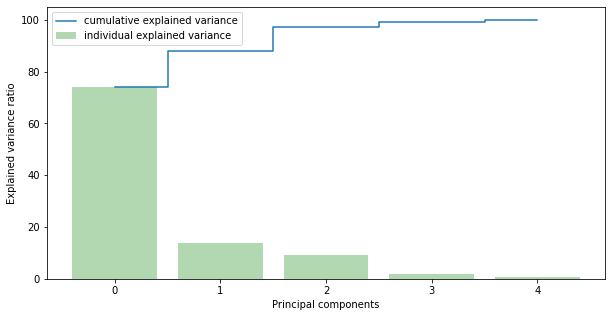

In [536]:
### Principal Components Analysis
# find the number of components (features) to keep                          
mean_vec = np.mean(data_train, axis=0)
cov_mat = np.cov(data_train.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0], reverse= True)
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

### 6. Anomaly Detection & Filtering

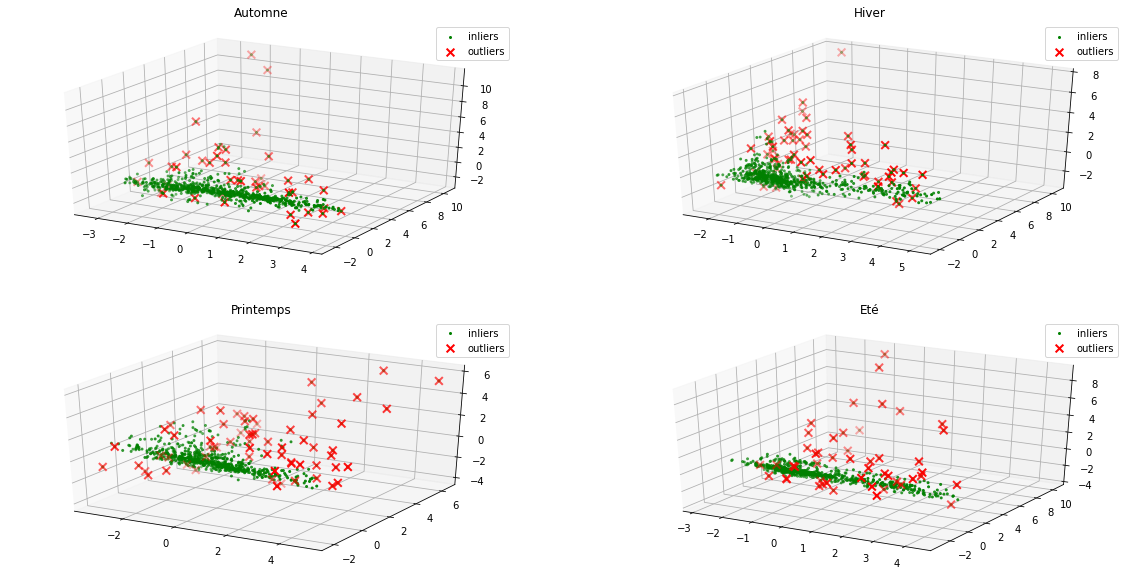

In [537]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn import svm
from sklearn.covariance import EllipticEnvelope

from mpl_toolkits.mplot3d import Axes3D

## Use fit_predict
DB = DBSCAN(eps =0.6, metric='euclidean', min_samples=3, n_jobs=-1)
LOF = LocalOutlierFactor(n_neighbors=5, contamination=0.01)
## Use predict
IForest=IsolationForest(n_estimators=100,max_samples='auto',contamination=0.01,max_features=1.0,bootstrap=True, n_jobs=-1, random_state=42, verbose=0)
#SVM=svm.OneClassSVM()
EE = EllipticEnvelope()

def build_detecor(data, detector):
    #scaling
    scaler = StandardScaler().fit(data)
    data = pd.DataFrame(scaler.transform(data), columns=data.columns, index=data.index)
    # PCA dimensionality reduction
    pca = PCA(n_components=3).fit(data) # !!! scaled training data
    data = pd.DataFrame(pca.transform(data), index=data.index, columns = ['PC1', 'PC2', 'PC3'])
    # anomaly detector
    detector = detector.fit(data)
    return scaler, pca, detector

def anomaly_detection(data, scaler, pca, detector):
    transformed_data = pd.DataFrame(scaler.transform(data), columns=data.columns, index=data.index)
    transformed_data = pd.DataFrame(pca.transform(transformed_data), index=transformed_data.index, columns = ['PC1', 'PC2', 'PC3'])
    #pred  = detector.predict(transformed_data)
    pred  = detector.fit_predict(transformed_data)
    data['anomaly'] = pred
    outliers = list(data[data['anomaly']==-1].index)    
    return transformed_data, data, outliers

def filter_outlier(X, outliers):
    X.loc[outliers, :] = np.nan
    X.interpolate(inplace=True)
    X.fillna(method='bfill',inplace=True)    
    return X

fig = plt.figure(figsize=(20,10))

outliers = [None] * 4

for index , subset_elem in enumerate(train_seasonal_data):
    
    ax = fig.add_subplot(2, 2, index+1, projection='3d')
    
    # build anomay detector
    scaler, pca, detector = build_detecor(subset_elem, DB)
    
    # anomaly detection
    transformed_data, seasonal_data[index], outliers[index] = anomaly_detection(seasonal_data[index], scaler, pca, detector)
    
    # Plot the compressed data points
    ax.scatter(transformed_data.loc[:,'PC1'], transformed_data.loc[:,'PC2'], zs=transformed_data.loc[:,'PC3'], s=4, lw=1, label="inliers",c="green")
    ax.scatter(transformed_data.loc[outliers[index],'PC1'],transformed_data.loc[outliers[index],'PC2'],transformed_data.loc[outliers[index],'PC3'],lw=2, s=60, marker="x", c="red", label="outliers")
    ax.title.set_text(saisons[index])
    ax.legend()    
    
    # filter anomalies
    seasonal_data[index] = filter_outlier(seasonal_data[index], outliers[index])    
    
plt.show()
    

In [538]:
def plot_anomalies(df, outliers, saison):
        
    fig = plt.figure(figsize=(20,10))
    plt.title(saison,fontsize=26, fontweight='bold')
    box = dict(facecolor='yellow', pad=5, alpha=0.2)  
    
    #Temp_min
    ax = fig.add_subplot(3, 2, 1)
    a = df.loc[outliers, ['Temp_min']] #anomaly
    ax.plot(df.index, df['Temp_min'], color='blue', label='Normal')
    ax.scatter(a.index,a['Temp_min'], color='red', label='Anomaly')
    plt.xlabel('Time')
    plt.ylabel('Temp_min', bbox=box)
    plt.legend()    
        
    #Temp_max
    ax = fig.add_subplot(3, 2, 2)
    a = df.loc[outliers, ['Temp_max']] #anomaly
    ax.plot(df.index, df['Temp_max'], color='blue', label='Normal')
    ax.scatter(a.index,a['Temp_max'], color='red', label='Anomaly')
    plt.xlabel('Time')
    plt.ylabel('Temp_max', bbox=box)
    plt.legend()
    
    #PLV
    ax = fig.add_subplot(3, 2, 3)
    a = df.loc[outliers, ['PLV']] #anomaly
    ax.plot(df.index, df['PLV'], color='blue', label='Normal')
    ax.scatter(a.index,a['PLV'], color='red', label='Anomaly')
    plt.xlabel('Time')
    plt.ylabel('PLV', bbox=box)
    plt.legend()
    
    #EVA
    ax = fig.add_subplot(3, 2, 4)
    a = df.loc[outliers, ['EVA']] #anomaly
    ax.plot(df.index, df['EVA'], color='blue', label='Normal')
    ax.scatter(a.index,a['EVA'], color='red', label='Anomaly')
    plt.xlabel('Time')
    plt.ylabel('EVA', bbox=box)
    plt.legend()
    
    #Vent
    ax = fig.add_subplot(3, 2, 5)
    a = df.loc[outliers, ['Vent']] #anomaly
    ax.plot(df.index, df['Vent'], color='blue', label='Normal')
    ax.scatter(a.index,a['Vent'], color='red', label='Anomaly')
    plt.xlabel('Time')
    plt.ylabel('Vent', bbox=box)
    plt.legend()
    plt.show()


In [539]:
'''    
for i in range(4):
    print('Detected anomalies for season:', saisons[i])
    plot_anomalies(seasonal_data[i].sort_index(), outliers[i], saisons[i])
'''

"    \nfor i in range(4):\n    print('Detected anomalies for season:', saisons[i])\n    plot_anomalies(seasonal_data[i].sort_index(), outliers[i], saisons[i])\n"

In [540]:
## concatunate cleaned seasonal data
if(ANOMALY):
    climatic_data_cleaned = pd.concat(seasonal_data)
    climatic_data_cleaned = climatic_data_cleaned.sort_index()

In [541]:
climatic_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2913 entries, 2005-09-01 to 2015-08-31
Data columns (total 6 columns):
Temp_max    2913 non-null float64
Temp_min    2913 non-null float64
Vent        2913 non-null float64
PLV         2913 non-null float64
EVA         2913 non-null float64
anomaly     2913 non-null float64
dtypes: float64(6)
memory usage: 159.3+ KB


# Concatunate climatic data & inflow

In [542]:
from sklearn.model_selection import train_test_split
def concatunate_inflow(data_cleaned, inflow): 
    data = data_cleaned.copy()
    data['APP'] = np.nan
    for year in sorted(pd.unique(pd.DatetimeIndex(inflow.index).year)):
        for month in range(1,13):
            index_app = list(inflow[np.logical_and(year==pd.DatetimeIndex(inflow.index).year, 
                                                   month==pd.DatetimeIndex(inflow.index).month)].index)
            index_data = list(data[np.logical_and(year==pd.DatetimeIndex(data.index).year, 
                                               month==pd.DatetimeIndex(data.index).month)].index)
            if len(index_data)>0 and len(index_app)>0:
                data.loc[index_data, 'APP'] = inflow.loc[index_app, 'APP'].values[0]   
    data.dropna(axis=0,inplace=True)
    return data

data_inflow = concatunate_inflow(climatic_data_cleaned, inflow)
data_inflow.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2913 entries, 2005-09-01 to 2015-08-31
Data columns (total 7 columns):
Temp_max    2913 non-null float64
Temp_min    2913 non-null float64
Vent        2913 non-null float64
PLV         2913 non-null float64
EVA         2913 non-null float64
anomaly     2913 non-null float64
APP         2913 non-null float64
dtypes: float64(7)
memory usage: 182.1+ KB


# Time Series Feature Engineering 

# concat seasonal_X[i]
all_seasonal_X = pd.concat(seasonal_X)
all_seasonal_data = pd.concat(seasonal_data)

print(all_seasonal_X.info())
print(all_seasonal_data.info())

#drop monthly series with nan inflow
X_clean = all_seasonal_X.loc[all_seasonal_data['APP'].notna()]
X_clean['APP'] = all_seasonal_data.loc[X_clean.index, 'APP']

# prepare test dataset
print('Missing values in test dataset:', data_test.isna().sum().sum())
X_comp_test['APP'] = data_test['APP']
X_comp_test.head()

clean_data_inflow = data_inflow.dropna(axis=0, inplace=False)
clean_data = clean_data_inflow.drop('APP', axis=1)
clean_data = pd.DataFrame(StandardScaler().fit_transform(clean_data), index=clean_data_inflow.index,
                          columns = clean_data.columns)
clean_data['APP'] = clean_data_inflow['APP'] 

In [543]:
from tsfresh import extract_features, extract_relevant_features
from tsfresh.feature_extraction import EfficientFCParameters, ComprehensiveFCParameters, MinimalFCParameters

extraction_settings = MinimalFCParameters()

def monthly_feature_extraction(df, method='describe'):   
    # Prepare time series : each monthly time serie has an ID and Time in range (0, length(serie))
    data = df.copy()
    data['ID'] = None
    data['Time'] = None
    ID = 1  
    ts_date = []
    for month in range(1,13): 
        for year in pd.unique(pd.DatetimeIndex(data.index).year):                   
            Serie_index = list(data[np.logical_and(year==pd.DatetimeIndex(df.index).year, 
                                        month==pd.DatetimeIndex(df.index).month)].index)
            if len(Serie_index)>0:
                time = list(range(0, len(Serie_index)))
                data.loc[Serie_index, 'ID'] = ID
                data.loc[Serie_index, 'Time'] = time
                ts_date.append(Serie_index[0])
                ID = ID+1  
                
    target = pd.Series(data.loc[data['Time']==0,'APP'].values, index=range(1,data['ID'].max()+1))
   
    if(method=='tsfresh'):
        features = extract_relevant_features(data.drop('APP', axis=1), target, column_id='ID', column_sort='Time',
                                             default_fc_parameters=extraction_settings)
    else:
        features = data.drop(['APP','Time'], axis=1).groupby(['ID']).describe() 
        #features.drop([('PC1', 'count'), ('PC2', 'count'), ('PC3', 'count')], axis=1, inplace= True)
        features.drop([('Temp_min', 'count'), ('Temp_max', 'count'), ('PLV', 'count'), ('EVA', 'count')], axis=1, inplace= True)
    
    features['DATE'] = ts_date
    features.set_index('DATE', inplace=True)        
    return features, target


def daily_feature_extraction(df, method='describe'):   
    # Prepare time series : each monthly time serie has an ID and Time in range (0, length(serie))
    data = df.copy()
    
    features = data.drop(['APP'], axis=1)
    target = data['APP']
    #features.drop([('PC1', 'count'), ('PC2', 'count'), ('PC3', 'count')], axis=1, inplace= True)
    #features.drop([('Temp_min', 'count'), ('Temp_max', 'count'), ('PLV', 'count'), ('EVA', 'count')], axis=1, inplace= True)
    
    return features, target

In [544]:
## Use statistical data : create monthly data
if  USE_DAILY_DATA == False:
    ts_features, ts_targets = monthly_feature_extraction(data_inflow)
## Use daily data : use the original data without any transformation or aggregation
else:
    ts_features, ts_targets = daily_feature_extraction(data_inflow)

In [545]:
names = []
for i in range(len(ts_features.columns)):
    names.append('F'+str(i))

ts_features= pd.DataFrame(ts_features.values, columns=names, index=ts_features.index)
ts_features.sort_index(inplace=True)

In [546]:
ts_features_targets = ts_features.copy()
ts_features_targets['APP'] = ts_targets.values
ts_features_targets.sort_index(inplace=True)

# Split & Scaling & Transformation

In [547]:
# split data into train & test sets
from sklearn.model_selection import train_test_split
X = ts_features_targets.drop('APP', axis=1)
y = ts_features_targets[['APP']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed, shuffle=True)

In [548]:
# scaling and transform data
from sklearn.preprocessing import PowerTransformer, StandardScaler
def data_scaling_transform(X_train, X_test, y_train, y_test):
    ### transform input variables
    scaler = StandardScaler().fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    ### transform target variables
    transformer = PowerTransformer().fit(y_train)
    y_train = transformer.transform(y_train)
    y_test = transformer.transform(y_test)     
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = data_scaling_transform(X_train, X_test, y_train, y_test)

# Modeling 

In [549]:
from sklearn.model_selection import KFold, cross_validate, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

def get_models():
    models = list()
    models.append(LinearRegression())
    models.append(HuberRegressor())
    models.append(Ridge())
    models.append(Lasso(max_iter=1500))
    models.append(KNeighborsRegressor(n_neighbors=3))
    models.append(SVR())
    models.append(DecisionTreeRegressor())
    models.append(ExtraTreeRegressor())
    models.append(BaggingRegressor(base_estimator=DecisionTreeRegressor()))
    models.append(RandomForestRegressor())
    models.append(ExtraTreesRegressor())
    models.append(AdaBoostRegressor(random_state=seed))
    models.append(GradientBoostingRegressor(random_state=seed))
    models.append(XGBRegressor(objective ='reg:squarederror'))
    models.append(MLPRegressor())
    return models

def train_test_models(X_train, y_train, X_test, y_test):
    result = pd.DataFrame()
    shuffle = KFold(n_splits=10, shuffle=True, random_state=seed)
    models = get_models()
    for index, model in enumerate(models):
        scores = cross_validate(model, X_train, y_train, cv=shuffle, scoring='r2',return_estimator=True)
        # index of best score
        pos_max = np.argmax(scores['test_score'])
        y_pred = scores['estimator'][pos_max].predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        models[index] = scores['estimator'][pos_max] 
        result = result.append(pd.DataFrame([[model.__class__.__name__, r2, sqrt(mse)]], columns=['Models','R2','RMSE']))
    return models, result 

models, result  = train_test_models(X_train, y_train, X_test, y_test)
print(result.reset_index(drop=True))

                       Models        R2      RMSE
0            LinearRegression -0.013221  1.164981
1              HuberRegressor -0.090066  1.208351
2                       Ridge -0.013208  1.164973
3                       Lasso -0.013240  1.164991
4         KNeighborsRegressor -0.220745  1.278731
5                         SVR -0.075334  1.200158
6       DecisionTreeRegressor -0.613943  1.470316
7          ExtraTreeRegressor -0.770130  1.539818
8            BaggingRegressor -0.085396  1.205760
9       RandomForestRegressor  0.044124  1.131534
10        ExtraTreesRegressor  0.031604  1.138920
11          AdaBoostRegressor  0.010910  1.151024
12  GradientBoostingRegressor -0.005455  1.160508
13               XGBRegressor  0.001633  1.156410
14               MLPRegressor -0.029251  1.174160


In [514]:
result.R2 = [round(r,3) for r in result.R2] 
result.RMSE = [round(r,3) for r in result.RMSE] 

In [515]:
result.to_csv('result_noised_data_DB.csv',sep=';', index=False)

In [ ]:
result_noised_data
result_original_data

result_original_data_EE
result_noised_data_EE

result_original_data_IFOREST
result_noised_data_IFOREST

result_noised_data_LOF
result_original_data_LOF


result_original_data_DB
result_noised_data_DB